In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error
import statsmodels.api as sm
import statsmodels.tsa.api as smt

In [6]:
data=pd.read_csv("Births2015.csv",index_col='date',parse_dates=[0])
data.drop('Unnamed: 0',axis=1,inplace=True)
data.head()

,births,wday,year,month,day_of_year,day_of_month,day_of_week
date,,,,,,,
2015-01-01,8068,Thu,2015,1,1,1,5
2015-01-02,10850,Fri,2015,1,2,2,6
2015-01-03,8328,Sat,2015,1,3,3,7
2015-01-04,7065,Sun,2015,1,4,4,1
2015-01-05,11892,Mon,2015,1,5,5,2


In [8]:
df=data['births']
df.head()

date
2015-01-01     8068
2015-01-02    10850
2015-01-03     8328
2015-01-04     7065
2015-01-05    11892
Name: births, dtype: int64

In [9]:
df.describe()

count      365.000000
mean     10899.991781
std       2076.683881
min       6515.000000
25%       8431.000000
50%      11883.000000
75%      12339.000000
max      13949.000000
Name: births, dtype: float64

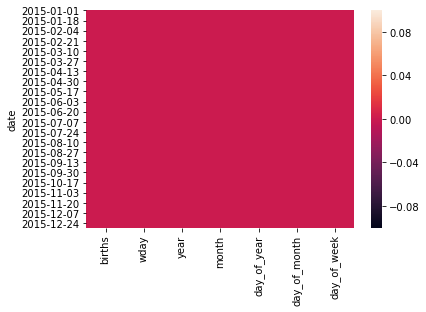

In [13]:
sns.heatmap(data.isna())

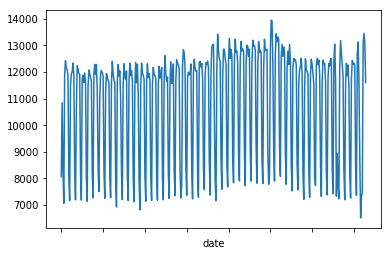

In [14]:
df.plot()

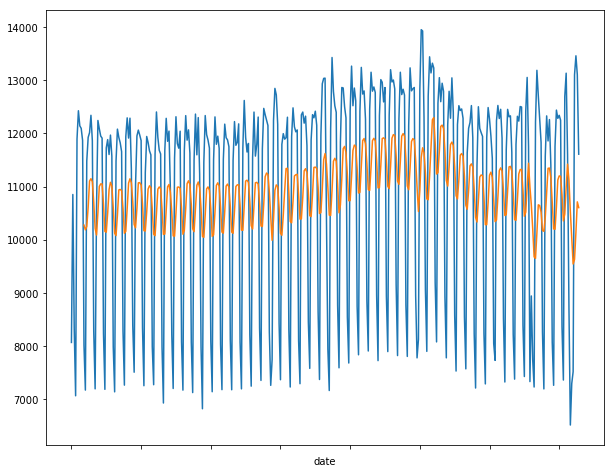

In [19]:
# Moving Average Smoothing:
movingavg=df.rolling(window=10).mean()
plt.figure(figsize=(10,8))
df.plot()
movingavg.plot()

# Baseline - Predict yesterdays value as today

In [22]:
df.head()

date
2015-01-01     8068
2015-01-02    10850
2015-01-03     8328
2015-01-04     7065
2015-01-05    11892
Name: births, dtype: int64

In [23]:
df.shift(1).head()

date
2015-01-01        NaN
2015-01-02     8068.0
2015-01-03    10850.0
2015-01-04     8328.0
2015-01-05     7065.0
Name: births, dtype: float64

In [25]:
base=pd.concat([df,df.shift(1)],axis=1)
base.columns=['births(t)','births(t+1)']
base.head()

,births(t),births(t+1)
date,,
2015-01-01,8068,NaN
2015-01-02,10850,8068.0
2015-01-03,8328,10850.0
2015-01-04,7065,8328.0
2015-01-05,11892,7065.0


In [28]:
print('RMSE:',mean_squared_error(base['births(t)'][1:],base['births(t+1)'][1:],squared=False))
print('MAE:',mean_absolute_error(base['births(t)'][1:],base['births(t+1)'][1:]))
print('r^2:',r2_score(base['births(t)'][1:],base['births(t+1)'][1:]))

RMSE: 2272.092334594498
MAE: 1558.6043956043957
r^2: -0.2032110847039792


# ARIMA - AutoRegressive (p) Integrated (d) Moving Average (q)

Tried to make a stationary series.   
Arima(p,q,d)         
              
First order diff: d=1            
Second order diff: d=2 etc

Identify seasonal trends - Check correlation between nth and (n-p)th terms.            
p=1 -> check corr(n,n-1)?              
p=2 -> check corr(n,n-2)?                  
p=p -> check corr(n,n-p)?               

In [32]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

## Find Q:
Use Plot_ACF
If the dot is above the light blue (critical region), then there is correlation present at q=x-axis value.         
Hence, we pick the last dot which is outside the critical region

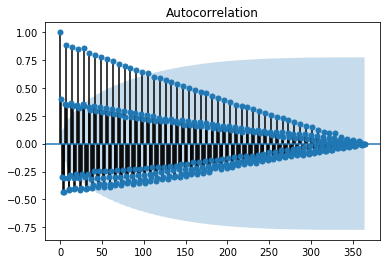

In [38]:
plot_acf(df)
plt.show()

## Find P:
Use Plot_PACF If the dot is above the light blue (critical region), then there is correlation present at p=x-axis value.
Hence, we pick the last dot which is outside the critical region

C:\Users\rohan\anaconda3\envs\prophet\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


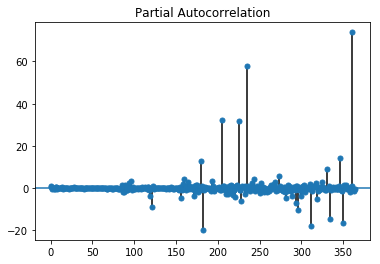

In [44]:
plot_pacf(df)
plt.show()

In [55]:
def dickeyFullerPlot(data,lag=10):
    plt.figure(figsize=(12,8))
    p=sm.tsa.stattools.adfuller(data)[1]
    plt.title('Dickey-Fuller Plot, p='+str(p))
    plt.plot(data)
    plt.show()

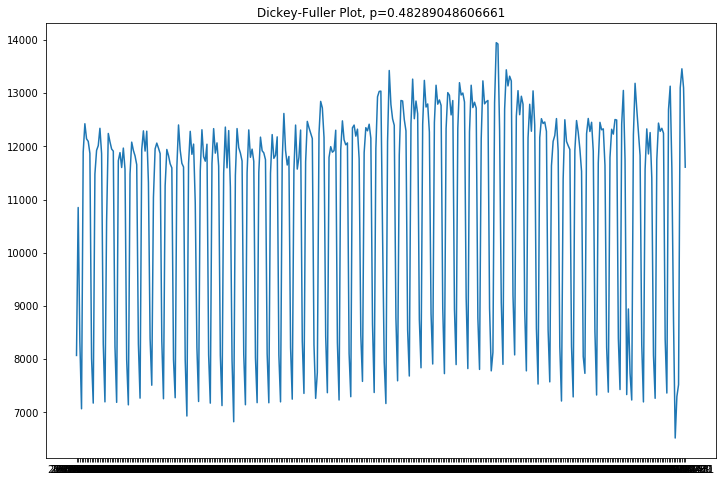

In [56]:
dickeyFullerPlot(df,30)

p>0.05, hence data is NOT Stationary

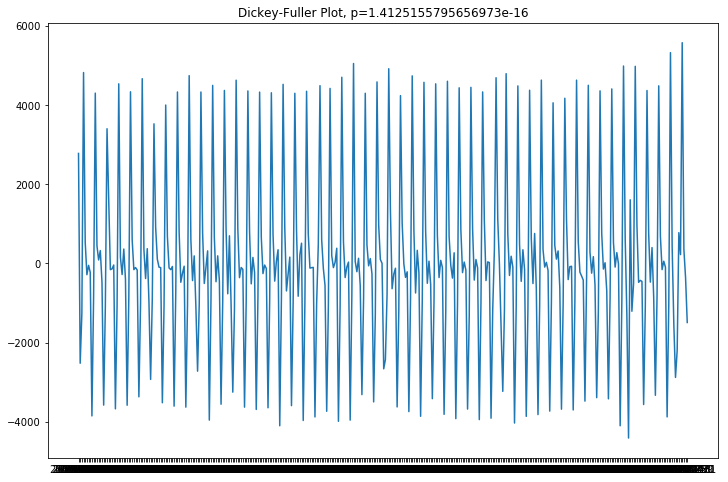

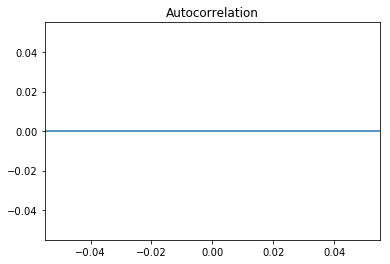

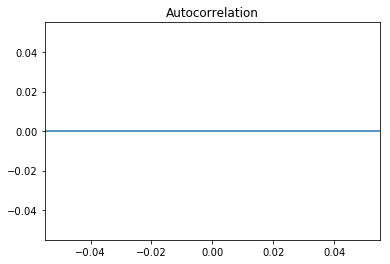

In [58]:
dataChangeInBirths=df - df.shift(1)
dickeyFullerPlot(dataChangeInBirths[1:],30)
plot_acf(dataChangeInBirths)

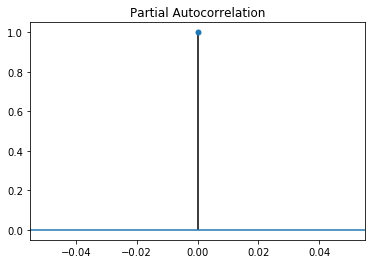

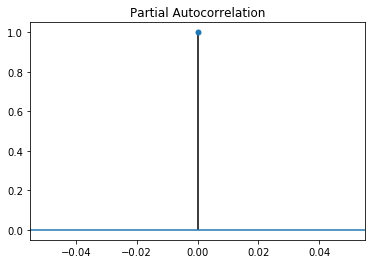

In [59]:
plot_pacf(dataChangeInBirths)

p<0.001 -> Reject H0 -> Data IS Stationary          
Autocorrelation plot is straight line. No correlation between successive values        
Partial AR is also a straight line. 

Hence, p and q are both 0, since no correlation exists between values IF d=1

In [46]:
# p=0, d=1, q=0
train=df[:330]
test=df[330:]
train.head()

date
2015-01-01     8068
2015-01-02    10850
2015-01-03     8328
2015-01-04     7065
2015-01-05    11892
Name: births, dtype: int64

In [47]:
from statsmodels.tsa.arima_model import ARIMA

In [77]:
model=ARIMA(train.astype('float64'),order=(0,1,0))

C:\Users\rohan\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\rohan\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [78]:
fittedmodel=model.fit()

In [79]:
fittedmodel.aic

6020.731779541046

In [80]:
preds=fittedmodel.forecast(steps=35)[0]

In [81]:
preds

array([7329.76291793, 7327.52583587, 7325.2887538 , 7323.05167173,
       7320.81458967, 7318.5775076 , 7316.34042553, 7314.10334347,
       7311.8662614 , 7309.62917933, 7307.39209726, 7305.1550152 ,
       7302.91793313, 7300.68085106, 7298.443769  , 7296.20668693,
       7293.96960486, 7291.7325228 , 7289.49544073, 7287.25835866,
       7285.0212766 , 7282.78419453, 7280.54711246, 7278.3100304 ,
       7276.07294833, 7273.83586626, 7271.59878419, 7269.36170213,
       7267.12462006, 7264.88753799, 7262.65045593, 7260.41337386,
       7258.17629179, 7255.93920973, 7253.70212766])

In [82]:
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error

In [85]:
print('MAE:',mean_absolute_error(test,preds))
print('r^2:',r2_score(test,preds))
print('MSE:',mean_squared_error(test,preds))
print('RMSE:',mean_squared_error(test,preds,squared=False))

MAE: 3389.182457663917
r^2: -2.0828099199361505
MSE: 16447611.997195153
RMSE: 4055.565558241557
